In [3]:
import pandahouse as ph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline
import plotly.express as px
import numpy as np

In [4]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [23]:
# создаем запрос, db автоматически заменится на значение из database
q = '''
    SELECT 
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price,
    room_type
    FROM 
        {db}.ldn_listings
    ORDER BY id ASC
    LIMIT 1000
    '''

# отправляем запрос и записываем результат в пандасовский датафрейм
q_test = ph.read_clickhouse(query=q, connection=connection_default)
q_test

,price,room_type
0,65.0,Private room
1,100.0,Entire home/apt
2,300.0,Entire home/apt
3,150.0,Private room
4,65.0,Entire home/apt
...,...,...
995,110.0,Entire home/apt
996,110.0,Entire home/apt
997,65.0,Private room
998,100.0,Entire home/apt


In [24]:
q_test

,price,room_type
0,65.0,Private room
1,100.0,Entire home/apt
2,300.0,Entire home/apt
3,150.0,Private room
4,65.0,Entire home/apt
...,...,...
995,110.0,Entire home/apt
996,110.0,Entire home/apt
997,65.0,Private room
998,100.0,Entire home/apt


In [31]:
test = q_test.groupby('room_type', as_index=False).quantile(q=0.75)

In [32]:
test

,room_type,price
0,Entire home/apt,160.00
1,Hotel room,157.00
2,Private room,70.00
3,Shared room,69.25


In [42]:
# создаем запрос, db автоматически заменится на значение из database
q = '''
    SELECT 
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price,
    toFloat32OrNull(replaceRegexpAll(review_scores_rating, '[$,]', '')) as review_scores_rating,
    room_type
    FROM 
        {db}.ldn_listings
    WHERE review_scores_rating is not null
    ORDER BY id ASC
    LIMIT 1000
    '''

# отправляем запрос и записываем результат в пандасовский датафрейм
df = ph.read_clickhouse(query=q, connection=connection_default)
df 

,price,review_scores_rating,room_type
0,65.0,97.0,Private room
1,100.0,96.0,Entire home/apt
2,300.0,94.0,Entire home/apt
3,65.0,93.0,Entire home/apt
4,29.0,96.0,Private room
...,...,...,...
995,165.0,100.0,Entire home/apt
996,99.0,93.0,Private room
997,45.0,100.0,Private room
998,20.0,88.0,Private room


In [43]:
df1 = df.groupby('room_type', as_index=False).agg({'price': 'mean', 'review_scores_rating': 'mean'})

In [44]:
df1

,room_type,price,review_scores_rating
0,Entire home/apt,135.882950,93.568787
1,Hotel room,134.000000,92.500000
2,Private room,54.642437,94.766205
3,Shared room,21.000000,90.000000


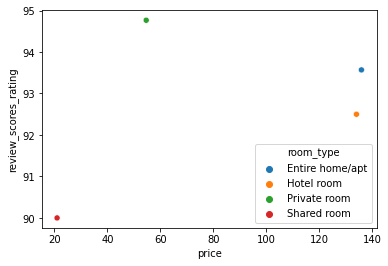

In [45]:
sns.scatterplot(data=df1, x='price', y='review_scores_rating', hue='room_type')

In [138]:
# создаем запрос, db автоматически заменится на значение из database
q = '''
    SELECT 
    distinct host_id,
    host_verifications
    FROM 
        {db}.ldn_listings
    WHERE experiences_offered != 'none'
    ORDER BY id ASC
    '''

# отправляем запрос и записываем результат в пандасовский датафрейм
df2 = ph.read_clickhouse(query=q, connection=connection_default)
df2 

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1356,21558962,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1357,21257846,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
1358,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1359,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."


In [139]:
df2.host_verifications = df2.host_verifications.apply(lambda x: x.strip('[]').replace("'", '').split(','))

In [140]:
df2.host_verifications.explode().value_counts()

email                     1345
 phone                    1345
 reviews                  1309
 government_id            1196
 jumio                    1115
 offline_government_id     469
 work_email                279
 facebook                  270
 selfie                    252
 identity_manual           227
 manual_offline             70
 google                     34
 kba                        27
 manual_online              16
phone                       16
 sent_id                     6
Name: host_verifications, dtype: int64

In [141]:
df2

,host_id,host_verifications
0,54730,"[email, phone, facebook, reviews, offline_..."
1,60302,"[email, phone, reviews, jumio, government_id]"
2,67915,"[email, phone, jumio, selfie, government_i..."
3,167107,"[email, phone, manual_offline, jumio, offl..."
4,103583,"[email, phone, reviews, offline_government_..."
...,...,...
1356,21558962,"[email, phone, reviews, jumio, government_id]"
1357,21257846,"[email, phone, reviews, jumio, offline_gov..."
1358,34219613,"[email, phone, reviews, jumio, government_id]"
1359,34299581,"[email, phone, google, reviews, jumio, of..."


In [165]:
# создаем запрос, db автоматически заменится на значение из database
q = '''
    SELECT 
    experiences_offered,
    neighbourhood_cleansed,
    count(experiences_offered) as experiences_count
    FROM 
        {db}.ldn_listings
    WHERE experiences_offered != 'none'
    group by neighbourhood_cleansed, experiences_offered
    ORDER BY experiences_count DESC
    limit 100
    '''

# отправляем запрос и записываем результат в пандасовский датафрейм
df3 = ph.read_clickhouse(query=q, connection=connection_default)
df3 

,experiences_offered,neighbourhood_cleansed,experiences_count
0,family,Hackney,61
1,business,Tower Hamlets,58
2,business,Westminster,50
3,social,Hackney,49
4,business,Hammersmith and Fulham,48
...,...,...,...
95,social,Redbridge,2
96,social,Barking and Dagenham,2
97,romantic,Newham,1
98,business,Bexley,1


In [166]:
df3 = df3.pivot(index = 'neighbourhood_cleansed', columns = 'experiences_offered', values = 'experiences_count')

In [167]:
cmap=sns.cubehelix_palette(as_cmap=True)

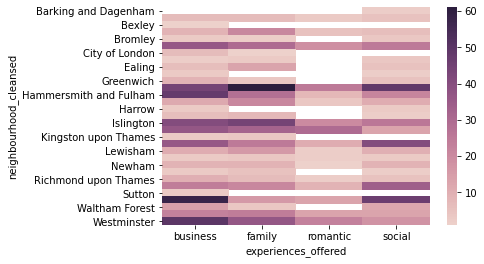

In [168]:
sns.heatmap(data = df3, cmap = cmap)


In [164]:
df3

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,1.0,NaN,NaN,2.0
Barnet,7.0,7.0,3.0,5.0
Bexley,1.0,NaN,NaN,NaN
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,1.0,4.0
Camden,NaN,30.0,19.0,25.0
City of London,7.0,1.0,1.0,NaN
Croydon,2.0,3.0,NaN,4.0
Ealing,6.0,13.0,1.0,5.0


In [169]:
# создаем запрос, db автоматически заменится на значение из database
q = '''
    SELECT 
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price
    FROM 
        {db}.ldn_listings
    WHERE experiences_offered != 'none'
    '''

# отправляем запрос и записываем результат в пандасовский датафрейм
df4 = ph.read_clickhouse(query=q, connection=connection_default)
df4 

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0
...,...,...
1543,Entire home/apt,100.0
1544,Entire home/apt,125.0
1545,Entire home/apt,185.0
1546,Entire home/apt,110.0


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


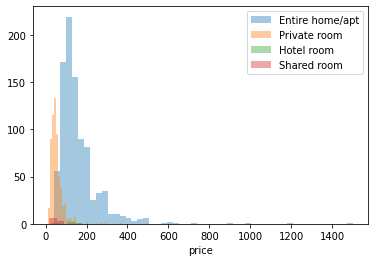

In [183]:
sns.distplot(df4.query("room_type=='Entire home/apt'").price, kde=False, label='Entire home/apt')
sns.distplot(df4.query("room_type=='Private room'").price, kde=False, label='Private room')
sns.distplot(df4.query("room_type=='Hotel room'").price, kde=False, label='Hotel room')
sns.distplot(df4.query("room_type=='Shared room'").room_type, kde=False, label='Shared room')
plt.legend()
plt.show()

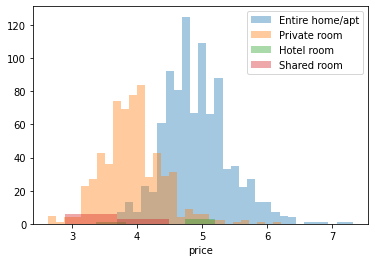

In [187]:
sns.distplot(np.log(df4.query("room_type=='Entire home/apt'").price), kde=False, label='Entire home/apt')
sns.distplot(np.log(df4.query("room_type=='Private room'").price), kde=False, label='Private room')
sns.distplot(np.log(df4.query("room_type=='Hotel room'").price), kde=False, label='Hotel room')
sns.distplot(np.log(df4.query("room_type=='Shared room'").price), kde=False, label='Shared room')
plt.legend()
plt.show()

In [16]:
# создаем запрос, db автоматически заменится на значение из database
q = '''
    SELECT 
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price,
    first_review 
    FROM 
        {db}.ldn_listings
    WHERE first_review > '2010-01-01'
    limit 1000
    '''

# отправляем запрос и записываем результат в пандасовский датафрейм
df5 = ph.read_clickhouse(query=q, connection=connection_default)
df5 

,room_type,price,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16
...,...,...,...
995,Private room,45.0,2012-11-07
996,Private room,51.0,2013-03-18
997,Entire home/apt,79.0,2012-09-17
998,Entire home/apt,110.0,2012-09-24


In [17]:
df5.first_review = df5.first_review.map(lambda x: str(x)[:-6])
df5

,room_type,price,first_review
0,Private room,65.0,2010
1,Entire home/apt,300.0,2011
2,Entire home/apt,65.0,2016
3,Private room,29.0,2010
4,Private room,100.0,2010
...,...,...,...
995,Private room,45.0,2012
996,Private room,51.0,2013
997,Entire home/apt,79.0,2012
998,Entire home/apt,110.0,2012


In [26]:
df5.first_review = df5.first_review.astype('float')

In [28]:
df5 = df5.sort_values(by='first_review')

In [29]:
df5

,room_type,price,first_review
0,Private room,65.0,2010.0
44,Private room,55.0,2010.0
39,Private room,75.0,2010.0
38,Entire home/apt,78.0,2010.0
33,Private room,45.0,2010.0
...,...,...,...
887,Private room,21.0,2019.0
277,Private room,105.0,2019.0
431,Private room,35.0,2019.0
12,Private room,39.0,2020.0


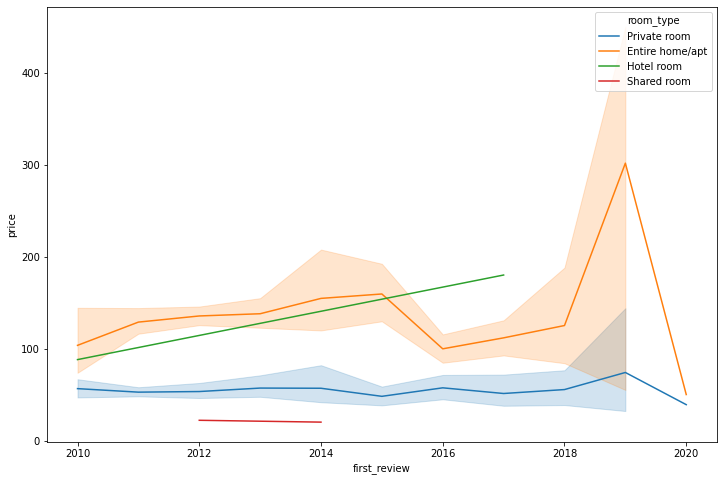

In [36]:
plt.figure(figsize=(12, 8))
sns.lineplot(x='first_review',y='price',hue='room_type',data=df5)